# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [ ]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`!

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
from torchvision import datasets, transforms

# Define transforms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),])

# Create training set and define training dataloader
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 196054508.80it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 113635735.29it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 167601090.46it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4543412.54it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [ ]:
sample_image, sample_label = next(iter(testloader))
#print("Original Image Size: ", sample_image.size())
print("Sample Image Shape: ", sample_image.shape)
print("Sample Label Shape: ", sample_label.shape)

Sample Image Shape:  torch.Size([64, 1, 28, 28])
Sample Label Shape:  torch.Size([64])


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?



 **This transformation normalizes the tensor by subtracting the mean of 0.5 and dividing by the standard deviation of 0.5. The mean and standard deviation values used here are commonly used for MNIST dataset normalization.**

**By using this transform pipeline, the MNIST dataset images will be converted to tensors and normalized, making them suitable for training deep learning models that expect normalized input data. Thus the preprocessing step is required.**


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [ ]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

4


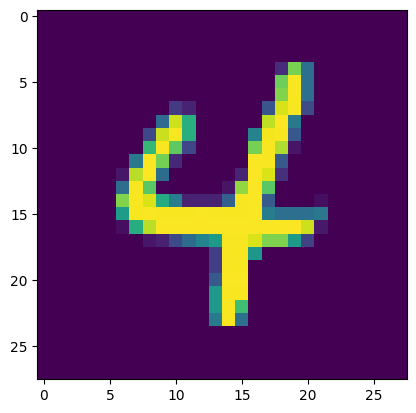

7


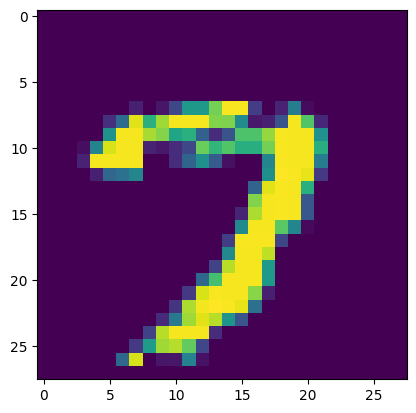

3


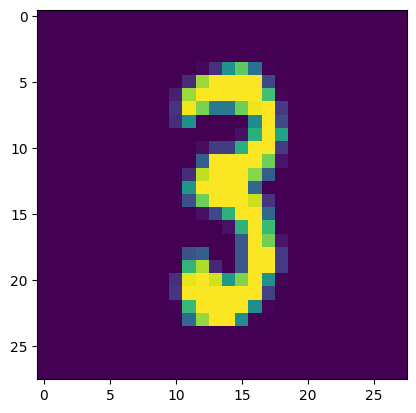

9


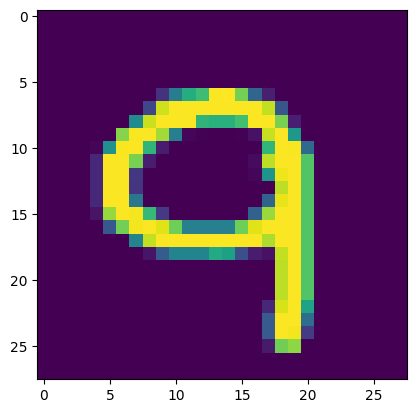

1


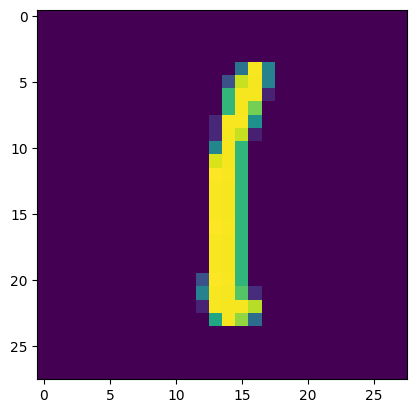

In [ ]:
# Explore data
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        #self.flatten = nn.Flatten()  # Could do that as well: add a flatten layer

        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        #x = self.flatten(x)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)

        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [ ]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 15
steps = 0

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

train_losses, test_losses = [], []
for e in range(epochs):

    running_loss = 0.0
    num_batches = 0
    train_correct = 0

    for batch_idx, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()


        _, preds = torch.max(log_ps.data, 1)
        train_correct += (preds == labels).sum().item()
        running_loss += loss.item()
        num_batches += 1

        if (batch_idx + 1) % 250 == 0:
            average_loss = running_loss / num_batches
            print(f"Epoch [{e+1}/{epochs}], Batch [{batch_idx+1}/{len(trainloader)}], Training Loss: {average_loss:.4f}, Training Accuracy: {train_correct/len(trainloader):.2f}%")

    else:

        test_loss = 0.0
        accuracy = 0
        test_correct = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in trainloader:
                images = images.to(device)
                labels = labels.to(device)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss.item()

                _, preds = torch.max(log_ps.data, 1)
                test_correct += (preds == labels).sum().item()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(trainloader))

        model.train()

        print("Epoch: [{}/{}].. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(trainloader)),
              "Test Accuracy: {:.3f}".format(test_correct/len(trainloader)))


Epoch [1/15], Batch [250/938], Training Loss: 0.0292, Training Accuracy: 16.91%
Epoch [1/15], Batch [500/938], Training Loss: 0.0286, Training Accuracy: 33.80%
Epoch [1/15], Batch [750/938], Training Loss: 0.0304, Training Accuracy: 50.68%
Epoch: [1/15]..  Training Loss: 0.031..  Test Loss: 0.026..  Test Accuracy: 63.399
Epoch [2/15], Batch [250/938], Training Loss: 0.0905, Training Accuracy: 16.57%
Epoch [2/15], Batch [500/938], Training Loss: 0.0877, Training Accuracy: 33.17%
Epoch [2/15], Batch [750/938], Training Loss: 0.0866, Training Accuracy: 49.78%
Epoch: [2/15]..  Training Loss: 0.086..  Test Loss: 0.033..  Test Accuracy: 63.251
Epoch [3/15], Batch [250/938], Training Loss: 0.0703, Training Accuracy: 16.68%
Epoch [3/15], Batch [500/938], Training Loss: 0.0699, Training Accuracy: 33.36%
Epoch [3/15], Batch [750/938], Training Loss: 0.0710, Training Accuracy: 50.01%
Epoch: [3/15]..  Training Loss: 0.075..  Test Loss: 0.034..  Test Accuracy: 63.309
Epoch [4/15], Batch [250/938], 

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# import matplotlib.pyplot as plt

# plt.plot(train_losses, label='Training loss')

# test_losses_cpu = [loss.cpu().item() for loss in test_losses]
# plt.plot(test_losses_cpu, label='Validation loss')



# plt.legend(frameon=False)


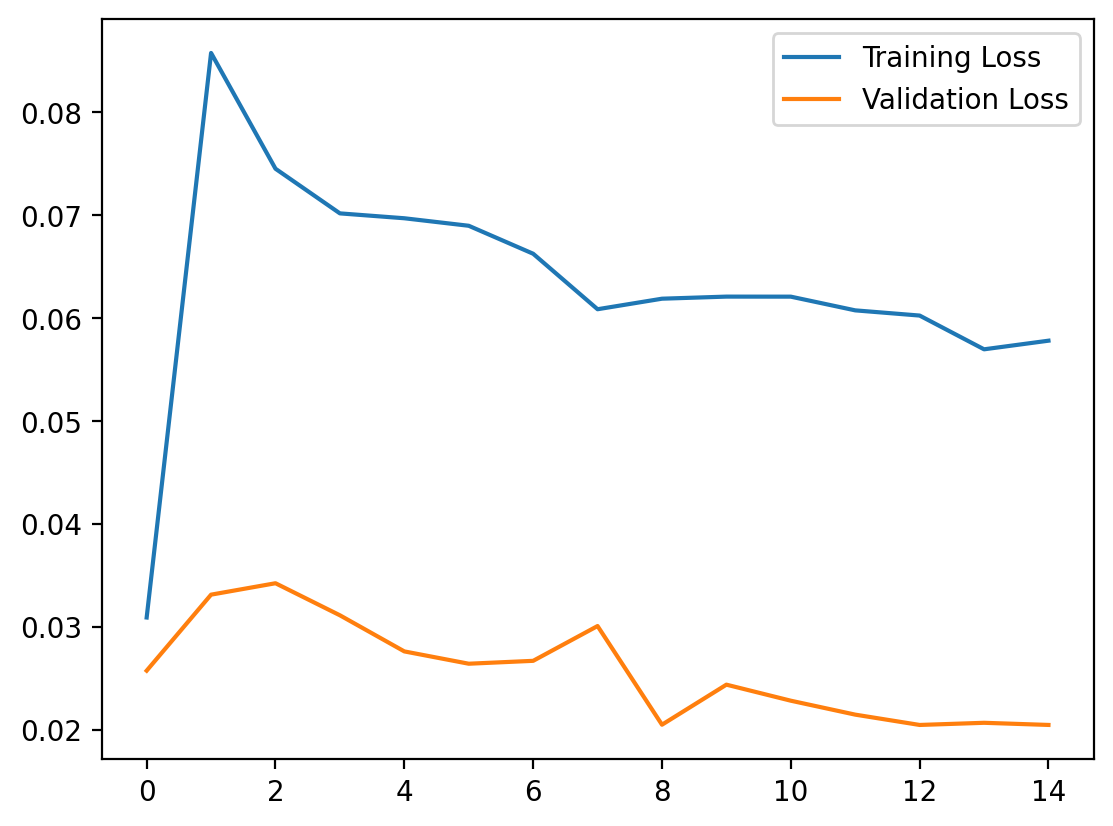

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss history
plt.plot(train_losses, label="Training Loss")
#test_losses_cpu = [loss.cpu().item() for loss in test_losses]
plt.plot(test_losses, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further!
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [ ]:

model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        _, preds = torch.max(log_ps.data, 1)

        total_samples += labels.size(0)
        total_correct += (preds == labels).sum().item()


accuracy = (total_correct / total_samples) * 100
print(round(accuracy, 2))


97.94


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

The Model can still be further trained as evident from the graph. But, a lower learning rate may help without increasing number of epochs.

In [ ]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
steps = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

train_losses, test_losses = [], []
for e in range(epochs):

    running_loss = 0.0
    num_batches = 0
    train_correct = 0

    for batch_idx, (images, labels) in enumerate(trainloader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()


        _, preds = torch.max(log_ps.data, 1)
        train_correct += (preds == labels).sum().item()
        running_loss += loss.item()
        num_batches += 1

        if (batch_idx + 1) % 250 == 0:
            average_loss = running_loss / num_batches
            print(f"Epoch [{e+1}/{epochs}], Batch [{batch_idx+1}/{len(trainloader)}], Training Loss: {average_loss:.4f}, Training Accuracy: {train_correct/len(trainloader):.2f}%")

    else:

        test_loss = 0.0
        accuracy = 0
        test_correct = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in trainloader:
                images = images.to(device)
                labels = labels.to(device)
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss.item()

                _, preds = torch.max(log_ps.data, 1)
                test_correct += (preds == labels).sum().item()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(trainloader))

        model.train()

        print("Epoch: [{}/{}].. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(trainloader)),
              "Test Accuracy: {:.3f}".format(test_correct/len(trainloader)))


Epoch [1/15], Batch [250/938], Training Loss: 0.6758, Training Accuracy: 13.40%
Epoch [1/15], Batch [500/938], Training Loss: 0.5081, Training Accuracy: 28.70%
Epoch [1/15], Batch [750/938], Training Loss: 0.4323, Training Accuracy: 44.29%
Epoch: [1/15]..  Training Loss: 0.394..  Test Loss: 0.183..  Test Accuracy: 60.341
Epoch [2/15], Batch [250/938], Training Loss: 0.2240, Training Accuracy: 15.88%
Epoch [2/15], Batch [500/938], Training Loss: 0.2128, Training Accuracy: 31.91%
Epoch [2/15], Batch [750/938], Training Loss: 0.2034, Training Accuracy: 48.00%
Epoch: [2/15]..  Training Loss: 0.200..  Test Loss: 0.113..  Test Accuracy: 61.727
Epoch [3/15], Batch [250/938], Training Loss: 0.1657, Training Accuracy: 16.20%
Epoch [3/15], Batch [500/938], Training Loss: 0.1622, Training Accuracy: 32.44%
Epoch [3/15], Batch [750/938], Training Loss: 0.1597, Training Accuracy: 48.69%
Epoch: [3/15]..  Training Loss: 0.157..  Test Loss: 0.107..  Test Accuracy: 61.840
Epoch [4/15], Batch [250/938], 

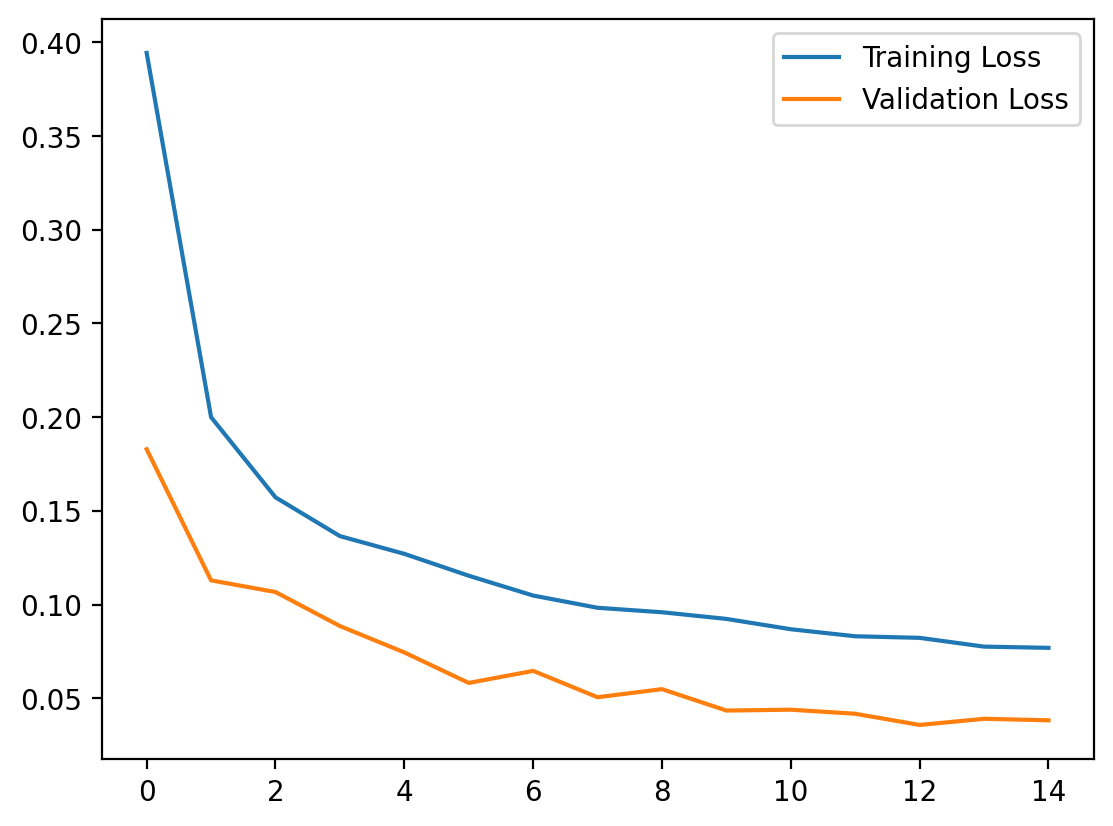

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation loss history
plt.plot(train_losses, label="Training Loss")
#test_losses_cpu = [loss.cpu().item() for loss in test_losses]
plt.plot(test_losses, label="Validation Loss")
plt.legend()
plt.show()

In [ ]:

model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        log_ps = model(images)
        _, preds = torch.max(log_ps.data, 1)

        total_samples += labels.size(0)
        total_correct += (preds == labels).sum().item()


accuracy = (total_correct / total_samples) * 100
print(round(accuracy, 2))


97.7


The accuracy on test set hasn't increased. That is possibly due to the lower learning rate (0.001) that was used this time. However, as we had kept the same number of epochs, model can improve if number of epochs are increased. But then again, the training loss and validation loss are nicely converging as can be seen from the end of the last graph. Further option can be explored with incresing hidden layers as well. But, a more complex model can overfit the dataset.

In [ ]:
print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

My model: 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:

torch.save(model.state_dict(), 'mnist_checkpoint.pth')


In [ ]:
#load the saved model

loaded_state_dict = torch.load('mnist_checkpoint.pth')
print(loaded_state_dict.keys())

model.load_state_dict(loaded_state_dict)
model

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)